In [ ]:
%gui qt

In [3]:
import napari
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
div_odd = lambda n: (n//2, n//2 + 1)
perc_diff = lambda a, b: abs(a-b)/((a+b)/2)
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage

real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(20,25)).zfill(3)))

#viewer = napari.view_image(real_image)


In [34]:
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/Lane_02_pos_002_trench_x_1963_y_0067_w_0046_h_0460_c_Phase.tif")[0][:300,:]


## FuncDefs

In [85]:
def run_simulation(trench_length, trench_width, cell_max_length, cell_width, sim_length):
    
    
    space = create_space()
    space.gravity = 0, -0.3 # arbitrasry units
    dt = 1/100 #time-step per frame
    pix_mic_conv = 10 # pixels per micron
    scale_factor = pix_mic_conv * 3 # resolution scaling factor 

    trench_length = trench_length*scale_factor
    trench_width = trench_width*scale_factor
    trench_creator(trench_width,trench_length,(35,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*3,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*5,0),space) # Coordinates of bottom left corner of the trench

    cell1 = Cell(
        length = cell_max_length*scale_factor,  
        width = cell_width*scale_factor, 
        resolution = 60, 
        position = (20+35,40), 
        angle = 0.8, 
        space = space,
        dt = 1/60,
        growth_rate_constant = 1,
        max_length = cell_max_length*scale_factor,
        max_length_mean =cell_max_length*scale_factor,
        max_length_var = 0.5*np.sqrt(scale_factor),
        width_var = 0.07*np.sqrt(scale_factor),
        width_mean = cell_width*scale_factor
    )


    cells = [cell1]
    cell_timeseries = []
    phys_iters = 100
    for x in range(sim_length):
        cells = step_and_update(dt=dt, cells=cells, space=space, phys_iters=phys_iters,ylim=trench_length)
        if x > 0:
            cell_timeseries.append(deepcopy(cells))
    return cell_timeseries, space


def get_similarity_metrics(real_image,synthetic_image):
    synthetic_image = match_histograms(synthetic_image, real_image, multichannel=False)
    synthetic_image = resize(synthetic_image,real_image.shape,clip=False,preserve_range=False,anti_aliasing=None)
    synthetic_image = synthetic_image/np.max(synthetic_image)
    ssim_real = ssim(synthetic_image, real_image)
    intersection = return_intersection_between_image_hists(synthetic_image, real_image, 100)
    #sims 
    synthetic_image_ = deepcopy(synthetic_image)
    synthetic_image_.shape += (1,)
    
    real_image_ = deepcopy(real_image)
    real_image_.shape += (1,)
    _fsim = fsim(synthetic_image_,real_image_)
    _issm = issm(synthetic_image_,real_image_)
    _sam = sam(synthetic_image_,real_image_)
    _sre = sre(synthetic_image_,real_image_)
    objs = [ssim_real, 0.5*intersection, _fsim, _issm, _sam, _sre/20]
    return objs

def generate_PC_OPL(main_segments, offset, scene, mask, media_multiplier,cell_multiplier,device_multiplier):
    def get_OPL_image():
        segment_1_top_left = (0 + offset, int(main_segments.iloc[0]["bb"][0] + offset))
        segment_1_bottom_right = (int(main_segments.iloc[0]["bb"][3] + offset), int(main_segments.iloc[0]["bb"][2] + offset))

        segment_2_top_left = (0 + offset, int(main_segments.iloc[1]["bb"][0] + offset))
        segment_2_bottom_right = (int(main_segments.iloc[1]["bb"][3] + offset), int(main_segments.iloc[1]["bb"][2] + offset))

        test_scene = np.zeros(scene.shape) + device_multiplier
        rr, cc = draw.rectangle(start = segment_1_top_left, end = segment_1_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * media_multiplier
        rr, cc = draw.rectangle(start = segment_2_top_left, end = segment_2_bottom_right, shape = test_scene.shape)
        test_scene[rr,cc] = 1 * media_multiplier
        circ_midpoint_y = (segment_1_top_left[1] + segment_2_bottom_right[1])/2
        radius = (segment_1_top_left[1] - offset - (segment_2_bottom_right[1] - offset))/2
        circ_midpoint_x = (offset) + radius

        rr, cc = draw.rectangle(start = segment_2_top_left, end = (circ_midpoint_x,segment_1_top_left[1]), shape = test_scene.shape)
        test_scene[rr.astype(int),cc.astype(int)] = 1 * media_multiplier
        rr, cc = draw.disk(center = (circ_midpoint_x, circ_midpoint_y), radius = radius, shape = test_scene.shape)
        rr_semi = rr[rr < (circ_midpoint_x + 1)]
        cc_semi = cc[rr < (circ_midpoint_x + 1)]
        test_scene[rr_semi,cc_semi] = device_multiplier
        no_cells = deepcopy(test_scene)
        test_scene += scene * cell_multiplier
        test_scene = test_scene[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        mask_resized = mask[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        
        no_cells = no_cells[segment_2_top_left[0]:segment_1_bottom_right[0],segment_2_top_left[1]:segment_1_bottom_right[1]]
        expanded_scene_no_cells = np.zeros((int(no_cells.shape[0]*1.2), no_cells.shape[1]*2)) + media_multiplier
        expanded_scene_no_cells[expanded_scene_no_cells.shape[0] - no_cells.shape[0]:,int(no_cells.shape[1]/2):int(no_cells.shape[1]/2) + no_cells.shape[1]] = no_cells

        expanded_scene = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2)) + media_multiplier
        expanded_scene[expanded_scene.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = test_scene
        
        expanded_mask = np.zeros((int(test_scene.shape[0]*1.2), test_scene.shape[1]*2))
        expanded_mask[expanded_mask.shape[0] - test_scene.shape[0]:,int(test_scene.shape[1]/2):int(test_scene.shape[1]/2) + test_scene.shape[1]] = mask_resized
        
        return expanded_scene, expanded_scene_no_cells, expanded_mask
    expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    if expanded_scene is None:
        main_segments = main_segments.reindex(index=main_segments.index[::-1])
        expanded_scene, expanded_scene_no_cells, expanded_mask = get_OPL_image()
    return expanded_scene, expanded_scene_no_cells, expanded_mask

def convolve_rescale(image,kernel,rescale_factor, rescale_int):
    output = cuconvolve(cp.array(image),cp.array(kernel))
    output = output.get()
    output = rescale(output, rescale_factor, anti_aliasing=False)
    
    if rescale_int:
        output = rescale_intensity(output.astype(np.float32), out_range=(0,1))
    return output

#make convolved image and real image same shape
def make_images_same_shape(real_image,synthetic_image, rescale_int = True):
    x_diff = synthetic_image.shape[1] - real_image.shape[1]
    remove_from_left, remove_from_right = div_odd(x_diff)
    y_diff = synthetic_image.shape[0] - real_image.shape[0]
    if y_diff > 0:
        synthetic_image = synthetic_image[y_diff:,remove_from_left-1:-remove_from_right]
    else:
        synthetic_image = synthetic_image[:,remove_from_left:-remove_from_right]
        real_image = real_image[abs(y_diff):,:]

    if rescale_int:
        real_image = rescale_intensity(real_image.astype(np.float32), out_range=(0,1))
        synthetic_image = rescale_intensity(synthetic_image.astype(np.float32), out_range=(0,1))
    return real_image, synthetic_image

def generate_test_comparison(media_multiplier, cell_multiplier, device_multiplier, sigma, scene_no, scale, match_histogram, match_noise, debug_plot=True, noise_var=0.002):
    
    
    expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
        main_segments=main_segments,
        offset=50,
        scene = scenes[scene_no][0],
        mask = scenes[scene_no][1],
        media_multiplier=media_multiplier,
        cell_multiplier=cell_multiplier,
        device_multiplier=device_multiplier
    )




    kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, sigma, 0.75)



    convolved = convolve_rescale(expanded_scene, kernel, 1/resize_amount, rescale_int = True)
    real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)
    
    
    if match_histogram:
        matched = match_histograms(expanded_resized, real_resize, multichannel=False)
    else:
        matched = expanded_resized
    
    
    noisy_img = random_noise(rescale_intensity(matched), mode="poisson")
    noisy_img = random_noise(rescale_intensity(noisy_img), mode="gaussian", mean=0,var=noise_var,clip=False)
    
    if match_noise:
        noisy_img = match_histograms(noisy_img, real_resize, multichannel=False)
    else:
        pass
    noisy_img = rescale_intensity(noisy_img.astype(np.float32), out_range=(0,1))
    
    ## getting the cell mask to the right shape
    expanded_mask_resized = rescale(expanded_mask, 1/resize_amount, anti_aliasing=False)
    _, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=True)


    

    
    expanded_media_mask = rescale((expanded_scene_no_cells == device_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool) , 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_media_mask = make_images_same_shape(real_image,expanded_media_mask, rescale_int=True)
    just_media = expanded_media_mask * noisy_img
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale_int=True)
    just_cells = expanded_cell_pseudo_mask * noisy_img
    
    expanded_device_mask = expanded_scene_no_cells == media_multiplier
    expanded_device_mask = rescale(expanded_device_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_device_mask = make_images_same_shape(real_image,expanded_device_mask, rescale_int=True)
    just_device = expanded_device_mask * noisy_img
    
    
    
    
    simulated_means = np.array([just_media[np.where(just_media)].mean(), just_cells[np.where(just_cells)].mean(), just_device[np.where(just_device)].mean()])
    simulated_vars = np.array([just_media[np.where(just_media)].var(), just_cells[np.where(just_cells)].var(), just_device[np.where(just_device)].var()])

    
    
    mean_error.append(np.mean(perc_diff(real_means, simulated_means)))
    media_error.append(perc_diff(simulated_means[0], real_media_mean))
    cell_error.append(perc_diff(simulated_means[1], real_cell_mean))
    device_error.append(perc_diff(simulated_means[2], real_device_mean))
    
    
    mean_var_error.append(np.mean(perc_diff(real_vars, simulated_vars)))
    media_var_error.append(perc_diff(simulated_vars[0], real_media_var))
    cell_var_error.append(perc_diff(simulated_vars[1], real_cell_var))
    device_var_error.append(perc_diff(simulated_vars[2], real_device_var))
    if debug_plot == True:
        fig = plt.figure(figsize=(15,5))
        ax1 = plt.subplot2grid((1,8),(0,0),colspan=1,rowspan=1)
        ax2 = plt.subplot2grid((1,8),(0,1),colspan=1,rowspan=1)
        ax3 = plt.subplot2grid((1,8),(0,2),colspan=3,rowspan=1)
        ax4 = plt.subplot2grid((1,8),(0,5),colspan=3,rowspan=1)
        ax1.imshow(noisy_img,cmap="Greys_r")
        ax1.set_title("Synthetic")
        ax1.axis("off")
        ax2.imshow(real_resize,cmap="Greys_r")
        ax2.set_title("Real")
        ax2.axis("off")
        ax3.plot(mean_error)
        ax3.plot(media_error)
        ax3.plot(cell_error)
        ax3.plot(device_error)
        ax3.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax3.set_title("Intensity Error")

        ax4.plot(mean_var_error)
        ax4.plot(media_var_error)
        ax4.plot(cell_var_error)
        ax4.plot(device_var_error)
        ax4.legend(["Mean error", "Media error", "Cell error", "Device error"])
        ax4.set_title("Variance Error")

        fig.tight_layout()
        plt.show()
        plt.close()
    else:
        return noisy_img, expanded_mask_resized_reshaped


In [149]:
sim_length = 1500
cell_timeseries, space = run_simulation(trench_length=15, trench_width=1.45, cell_max_length=5.5, cell_width=1.05, sim_length = sim_length)
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=14)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in cell_timeseries)
do_transformation = False
offset = 80
scenes = Parallel(n_jobs=14)(delayed(draw_scene)(
    cell_properties, do_transformation) for cell_properties in tqdm(cell_timeseries_properties))
#OPL_scenes = [generate_PC_OPL(main_segments, offset, scene[0], media_multiplier,cell_multiplier,device_multiplier) for scene in scenes]
#OPL_scenes_convolved = np.array([convolve_rescale(OPL_scene,kernel,1) for OPL_scene in OPL_scenes])

100%|██████████| 1499/1499 [10:43<00:00,  2.33it/s]


In [19]:
media_multiplier=-30
cell_multiplier=-1
device_multiplier=150


condensers = get_condensers()
W, R, diameter = condensers["Ph2"]
scale = 0.108379937 / 3 #0.35 #micron per pixel
min_sigma = 0.42*0.6/6 / scale # micron

resize_amount = 1/scale/10



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
    main_segments=main_segments,
    offset=50,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=1,
    cell_multiplier=1,
    device_multiplier=1
)

temp_kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, min_sigma, 0.75)



convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [12]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))



mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []



In [72]:
params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.1),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*4, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=scale,
    match_histogram = [True, False],
    match_noise = [True, False]);

In [73]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [153]:
np.random.choice([True, False])

False

In [157]:
def generate_training_data(interactive_output, sample_amount, randomise_hist_match, randomise_noise_match, sim_length, burn_in, n_samples, save_dir):
    media_multiplier, cell_multiplier, device_multiplier, sigma, scene_no, scale, match_histogram, match_noise, debug_plot, noise_var = list(interactive_output.kwargs.values())
    debug_plot = False
    
    try:
        os.mkdir(save_dir + "/convolutions")
    except:
        pass
    try:
        os.mkdir(save_dir + "/masks")
    except:
        pass
        
    
    #for z in range(n_samples):
    def generate_samples(z):
        _media_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * media_multiplier
        _cell_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * cell_multiplier
        _device_multiplier = np.random.uniform(1-sample_amount,1+sample_amount) * device_multiplier
        _sigma = np.random.uniform(1-sample_amount,1+sample_amount) * sigma
        _scene_no = np.random.randint(burn_in,sim_length-2)
        _noise_var = np.random.uniform(1-sample_amount,1+sample_amount) * noise_var
        if randomise_hist_match:
            _match_histogram = np.random.choice([True, False])
        if randomise_noise_match:
            _match_noise = np.random.choice([True, False])
        
        syn_image, mask = generate_test_comparison(_media_multiplier, _cell_multiplier, _device_multiplier, _sigma, _scene_no, scale, _match_histogram, match_noise, debug_plot, noise_var)
        
        syn_image = Image.fromarray(skimage.img_as_uint(rescale_intensity(syn_image)))
        syn_image.save("{}/convolutions/synth_{}.tif".format(save_dir, str(z).zfill(4)))
        mask = Image.fromarray(mask)
        mask.save("{}/masks/synth_{}.tif".format(save_dir, str(z).zfill(4)))        
    ## TODO: change parallel if not using GPU
    Parallel(n_jobs=1)(delayed(generate_samples)(z) for z in tqdm(range(n_samples)))

In [158]:
generate_training_data(interactive_output = params, sample_amount = 0.075, randomise_hist_match = True, randomise_noise_match = True, sim_length = sim_length, burn_in = 100, n_samples =  5000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/")



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 2/5000 [00:00<05:47, 14.37it/s]

  0%|          | 4/5000 [00:00<05:56, 14.02it/s]

  0%|          | 6/5000 [00:00<05:31, 15.07it/s]

  0%|          | 8/5000 [00:00<05:16, 15.78it/s]

  0%|          | 10/5000 [00:00<05:07, 16.22it/s]

  0%|          | 12/5000 [00:00<04:51, 17.12it/s]

  0%|          | 14/5000 [00:00<04:48, 17.27it/s]

  0%|          | 16/5000 [00:00<04:50, 17.16it/s]

  0%|          | 18/5000 [00:01<04:49, 17.22it/s]

  0%|          | 20/5000 [00:01<04:50, 17.13it/s]

  0%|          | 22/5000 [00:01<04:47, 17.31it/s]

  0%|          | 24/5000 [00:01<04:52, 17.01it/s]

  1%|          | 26/5000 [00:01<04:42, 17.64it/s]

  1%|          | 28/5000 [00:01<04:47, 17.28it/s]

  1%|          | 30/5000 [00:01<04:48, 17.23it/s]

  1%|          | 32/5000 [00:01<04:38, 17.82it/s]

  1%|          | 34/5000 [00:01<04:34, 18.09it/s]

  1%|          | 36/5000 [00:02<04:29, 18.44it/s]

  1%|          | 38/5000 [00:02<04:25, 18.

In [128]:
def get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount):
    expanded_media_mask = rescale((expanded_scene_no_cells == device_multiplier) ^ (expanded_scene - expanded_scene_no_cells).astype(bool) , 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_media_mask = make_images_same_shape(real_image,expanded_media_mask, rescale_int=True)
    just_media = expanded_media_mask * expanded_resized
    
    expanded_cell_pseudo_mask = (expanded_scene - expanded_scene_no_cells).astype(bool)
    expanded_cell_pseudo_mask = rescale(expanded_cell_pseudo_mask, 1/resize_amount, anti_aliasing=False)

    real_resize, expanded_cell_pseudo_mask = make_images_same_shape(real_image,expanded_cell_pseudo_mask, rescale_int=True)
    just_cells = expanded_cell_pseudo_mask * expanded_resized
    
    expanded_device_mask = expanded_scene_no_cells == media_multiplier
    expanded_device_mask = rescale(expanded_device_mask, 1/resize_amount, anti_aliasing=False)
    real_resize, expanded_device_mask = make_images_same_shape(real_image,expanded_device_mask, rescale_int=True)
    just_device = expanded_device_mask * expanded_resized
    
    return just_media, just_cells, just_device, expanded_media_mask, expanded_cell_pseudo_mask, expanded_device_mask

just_media, just_cells, just_device, perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask = get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount)

NameError: name 'expanded_scene' is not defined

In [48]:
def get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, expanded_resized):
    return (perm_expanded_media_mask * expanded_resized).mean(), (perm_expanded_cell_pseudo_mask * expanded_resized).mean(), (perm_expanded_device_mask * expanded_resized).mean()

In [21]:
OPL_image_convolved = []
global current_error
current_error = 10
best_input = []

def objective_function(v, return_diagnostics = False):
    global current_error
    media_multiplier, cell_multiplier, device_multiplier= v
    expanded_scene, expanded_scene_no_cells, expanded_mask = generate_PC_OPL(
    main_segments=main_segments,
    offset=50,
    scene = scenes[4][0],
    mask = scenes[4][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=device_multiplier
    )


    resize_amount = 1/scale/10

    ## Creating the synthetic image
    kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, 7, 0.6)
    convolved = convolve_rescale(expanded_scene, kernel, resize_amount, rescale_int = True)
    real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

    ## getting the cell mask to the right shape
    expanded_mask_resized = rescale(expanded_mask,1/resize_amount, anti_aliasing=False)
    real_resize, expanded_mask_resized_reshaped = make_images_same_shape(real_image,expanded_mask_resized, rescale_int=True)
    _, _, _, perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask = get_images_to_optimise(expanded_scene,expanded_scene_no_cells,expanded_resized, real_image, convolved, resize_amount)
    simulated_means = np.array(get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, expanded_resized))

    perc_sum = sum(perc_diff(real_means, simulated_means))

    if perc_sum < current_error:
        current_error = perc_sum
        print(current_error)
        best_input.append(v)
        OPL_image_convolved.append(expanded_resized)
    
    if return_diagnostics == True:
        return expanded_resized, simulated_means, perc_sum
    else:
        if np.isnan(perc_sum):
            return 100
        else:
            return perc_sum

In [193]:
objective_function(np.array([-20,-1,20]), return_diagnostics = True)[1]

4.770970038029978


array([0.07229291, 0.07229291, 0.        ])

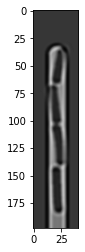

In [25]:
plt.imshow(objective_function(np.array([-20,-1,10]), return_diagnostics = True)[0], cmap="Greys_r", vmax=1.5)

In [196]:
(perm_expanded_cell_pseudo_mask*objective_function(np.array([-20,-1,20]), return_diagnostics = True)[0]).mean()

0.08446355586255212

In [199]:
get_intensity_means(perm_expanded_media_mask, perm_expanded_cell_pseudo_mask, perm_expanded_device_mask, objective_function(np.array([-20,-1,20]), return_diagnostics = True)[0])

(0.0870561185720817, 0.08446355586255212, 0.15488408330597386)

In [90]:
perc_diff = lambda a, b: abs(a-b)/abs((a+b)/2)


In [69]:
progress = []
def callbackF(x, f, context):
    print(x)
    progress.append(x)
    
def callbackSHGo(x):
    print(x)
    progress.append(x)

In [98]:
bounds = list(zip([-500, -500, -500], [500.0, 500.0, 500.0]))

In [71]:
#ret = shgo(objective_function, bounds = np.array(bounds),callback=callbackSHGo,options={"minimize_every_iter":True})
ret = dual_annealing(objective_function, bounds = np.array(bounds),callback=callbackF) # ,maxiter=10,initial_temp=5*10**4

5.128858857946668
4.10670254594746
[8.3984143  9.36400079 3.7158313  4.73860291]
4.10670254464104
4.106702491492569
4.106702490414254
4.106702489688466
4.106702488153941
4.106702487739205
4.10670248763552
4.106702486888995
[8.3984143  9.36400083 3.7158313  4.73860265]
4.103727135097859
[30.35820404  9.67548262 11.10249933  4.86540442]
4.10372713352352
4.103727105475417
[30.35820404  9.67548268 11.10249934  4.86540423]
3.9178050160753006
[-46.94165656   1.79973916 -13.57738821   4.80477925]
3.917805012044604
3.917804977589897
3.917804973869254
3.917804973791741
3.9178049703423943
3.9178049217414928
3.9178049172457152
3.9178049151916103
3.9178049146490164
3.9178049145327467
[-46.94165656   1.79973948 -13.5773882    4.80477903]
3.792588391037277
[-39.84664562   1.38914512  33.52348986   4.13033935]
3.7925883882240687
3.792587543114208
3.79258753922754
3.79258579033847
3.792585788487677
3.792575383903742
3.792575381386673
3.792518291940931
3.7925182889797355
3.7922909753818543
3.7922909719

KeyboardInterrupt: 

In [75]:
ret = basinhopping(objective_function, x0 = (0,0,0),callback=callbackF) 

6.0
4.1138041666894
4.113804123178086
4.113804120163686
4.113803937002476
4.113103037942554
4.1131027214465945
4.111649807649282
4.1116494335354155
4.099482613628385
4.09948224417289
4.087844421557999
4.0878440857370695
4.086239202906624
4.086238795531267
4.084957692682755
4.084957388401355
4.084294863420842
4.084294527919816
4.084291711547868
4.084291409498532
4.084289118845636
4.084288818648124
4.084287708748749
4.084287304247625
4.084287140180076
4.084286804967988
4.084286543056571
4.084286208297154
4.084286201055555
4.084285794764821
4.084285740679132
4.084285440337972
4.084283750063202
4.084283410839841
4.084278661614201
4.084278568193703
4.084278555952965
4.084278505056179
[ 5.44936185e-04  5.12591331e-05 -6.91679505e-04]
[0.33578976 0.76325799 0.40842093]
4.06226719249729
4.062267150019293
3.9752033628634185
3.97520333021764
3.922207761514856
3.922207761437218
3.9222077323231357
3.9010601349329614
3.901060108468933
3.8371940703964196
3.8371940690417192
3.7364840631293186
3.73648

KeyboardInterrupt: 

In [99]:
from scipy.optimize import differential_evolution

In [100]:
ret = differential_evolution(objective_function, bounds, popsize = 200, mutation = 1.999)

2.711381036766328


KeyboardInterrupt: 

In [102]:
ranges = [np.arange(-50,50, 5), np.arange(-50,50, 5), np.arange(-50,50, 5)]

In [103]:
inputs = (list(itertools.product(*ranges)))

In [104]:
import random

In [107]:
np.random.uniform(low=-1000,high=1000,size=(3))

array([ 541.92660613, -264.23806488,  194.76760152])

In [110]:
OPL_image_convolved = []
current_error = 10
best_input = []
a = 0
while True:    
    temp_output = objective_function(np.random.uniform(low=-1000,high=1000,size=(3)), True)
    a+=1
    if temp_output[1] < current_error:
        current_error = temp_output[1]
        print(current_error)
        best_input.append(list(input_) + [3.9])
        OPL_image_convolved.append(temp_output[0])


6.43587413656236
4.413323889073245
3.383942598242193
2.7349827643629308
2.7347629271453417
2.732054628102208
2.721586495654492
2.7194494669055262
2.7179394258712675
2.714491961495808
2.7136971336331017
2.712607493175978
2.7124040288726134
2.7116845677474086
2.711595366597879
2.7110131818894994
2.7110065438873745


KeyboardInterrupt: 

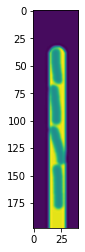

In [112]:
plt.imshow(OPL_image_convolved[-1])